## Testing single-object lightcurves from PDAC 

Here I query PDAC v.1 SUIT  http://lsst-sui-proxy01.ncsa.illinois.edu/suit against a few variable objects. I consider 483 RR Lyrae stars from Sesar +2010 http://iopscience.iop.org/article/10.1088/0004-637X/708/1/717/meta#apj326724t2   . Table 1 in that paper contains positions and photometry , one file per object  (the name of each file is elsewhere in the paper, and in Table 1, called RR Lyrae ID).  Table 2 contains lightcurve parameters, and can be matched to photometry files by RR Lyrae ID  (col 0). Table 2 also includes the RR Lyrae type (col 1),  and Period in days (col 2) 

In [75]:
# necessary imports
import numpy as np
import os
import pandas as pd 
from astropy.table import Table
from astropy.table import Column
from astropy.io import ascii
import matplotlib.pyplot as plt
import json

# periodogram-related 
import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/')
import frequencyFunctions as freq
import imp
imp.reload(freq)
from astroML.time_series import lomb_scargle  ,lomb_scargle_bootstrap 


I download the lightcurves from the supplementary data file to Table 1 ( http://iopscience.iop.org/0004-637X/708/1/717/suppdata/apj326724_table1.tar.gz )

In [2]:
DirIn = '../catalogs/RRLyr_S82_Sesar_2010/'
address1 = DirIn + 'table1_lightcurves/'

# find out what are the IDs of RR Lyr available as lightcurves
#RRLyr_lc_files = os.listdir(address1)
# remove ReadMe..
#RRLyr_lc_files.pop(-1)
# strip the *.txt from filename 
#RRLyr_ID = [int(ID[:-4]) for ID in RRLyr_lc_files]

I downloaded Branimir's fit parameters as machine-readable version of Table 2 : http://iopscience.iop.org/0004-637X/708/1/717/suppdata/apj326724t2_mrt.txt


In [212]:
# Grab the fit parameters...
table2 = Table.read(DirIn+'table2_lc_fit_params.txt', format='ascii') 



I first plot the distribution of  RR Lyr periods from Table 2 :

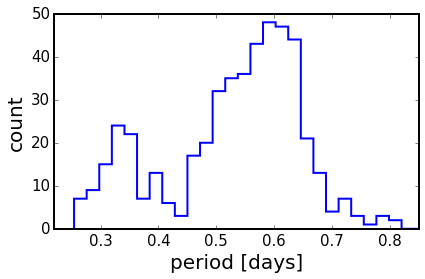

In [318]:
fig,ax = plt.subplots()
ax.hist(table2['Per'].data, bins=30, histtype='step', lw=2)
ax.set_ylabel('count')
ax.set_xlabel('period [days]')
ax.set_xlim(xmin = 0.22, xmax=0.85)

#ax.set_title('483 RR Lyrae from Sesar+2010')
plt.tight_layout()
plt.savefig('../data_products/Fig_1_Sesar_2010_RRLyr.png')

Each lightcurve file has multiple columns, and the metadata for these is in the Readme file.

At the moment RA, Dec information is in each lightcurve (first cols), whereas all other info is in table 2.  I want to add this info to table 2 to make a master table with the information I need (one row per RR Lyr).

In [221]:
# table 2 : 'Num', 'Type', 'Per', 'Au', 'umag', 'phiu', 'Tu', 'Ag', 'gmag',
#       'phig', 'Tg', 'Ar', 'rmag', 'phir', 'Tr', 'Ai', 'imag', 'phii',
#       'Ti', 'Az', 'zmag', 'phiz', 'Tz'


# Grab the fit parameters...
table2 = Table.read(DirIn+'table2_lc_fit_params.txt', format='ascii') 

# Grab the RR Lyr ID 
lc_names = table2['Num'].data.astype(str)

# grab colnames and units for all RR Lyr LC lightcurves  from the readme file....
readme = Table.read(DirLc+'ReadMe', format='ascii')

# initialize empty arrays to store that info 
ra = np.zeros_like(lightcurves, dtype=float)
dec = np.zeros_like(lightcurves, dtype=float)
# iterate in a loop over all lightcurves pulling the 
# ra, dec from the first row of each LC
for i in range(len(lc_names)) : 
    
    lc = Table.read(DirLc+ lc_names[i]+'.dat', format='ascii')
    
    # Grab the colnames and units from the Readme file...
    columns = lc.colnames

    for j in range(len(columns)):
        lc[columns[j]].name = readme.colnames[j]
        lc[readme.colnames[j]].unit = readme[readme.colnames[j]].unit

    ra[i] = lc['RAdeg'][0]
    dec[i]  = lc['DEdeg'][0]

r = Column(data=ra, name='RAdeg')
d = Column(data=dec, name='DEdeg')
ic = Column(np.arange(len(lc_names)), 'i')

table2.add_columns([r,d,ic])

# Now table2 has three additional columns that together give me all the info I need about all RR Lyr...
# Choose only those columns that we need .
master_table = table2[['i','RAdeg','DEdeg','Num', 'Type', 'Per', 'gmag']]




In [300]:
np.unique(master_table['Type'].data)

array(['ab', 'c'], 
      dtype='<U2')

To test things out, I focus on one lightcurve :

In [235]:
# Pick an RR Lyr, print it's mag,  type, and plot the lightcurve 

i = 0
lc = Table.read(address1+lc_names[i]+'.dat', format='ascii')

# Rename the columns and units for this lightcurve ...
columns = lc.colnames

for j in range(len(columns)):
    lc[columns[j]].name = readme.colnames[j]
    lc[readme.colnames[j]].unit = readme[readme.colnames[j]].unit

# grab period and type for that particular RR Lyr...
ID = master_table['Num'][i]
period =master_table['Per'][i]  # in days 
rr_type = master_table['Type'][i] # string 
print('We picked RR Lyrae ID=%d , type %s, with a period of %.4f days'%(ID,rr_type, period))

We picked RR Lyrae ID=4099 , type ab, with a period of 0.6418 days


Plot raw lightcurve and period - folded lightcurve : 1)  use Branimir's period 2) do Lomb-Scargle to find period

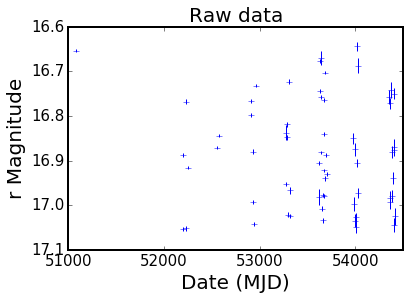

In [236]:
# Some settings to make all fonts bigger

from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

def plot_data(source_mjds, source_mags, source_magerrs, ax = None, band=''): # COMPLETE THIS LINE
    ax.errorbar(source_mjds, source_mags, source_magerrs, # COMPLETE THIS LINE
        fmt = '_', capsize=0)
    ax.set_xlabel('Date (MJD)')
    ax.set_ylabel(band+' Magnitude')
    ax.set_title('Raw data')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2])
    plt.gca().invert_yaxis()
    
%matplotlib inline 

band = 'r'
mask =  lc[band+'mag'] > 0   # remove all rows missing data... 
mjds = lc[band+'mjd'][mask]
mags = lc[band+'mag'][mask]
magerrs = lc[band+'magErr'][mask]
fig,ax = plt.subplots()
plot_data(mjds,mags, magerrs,ax,band)

I'll phase this raw lightcurve on Branimir's period to see how well it fares

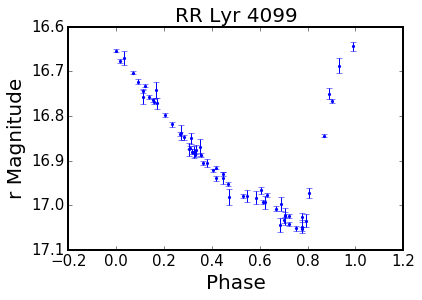

In [240]:
# define function to phase lightcurves
def phase(time, period, t0 = None):
    """ Given an input array of times and a period, return the corresponding phase."""
    if t0 is None:
        t0 = time[0]
        phase = ((time - t0) % period)/period
    return phase # COMPLETE

# define function to plot phased lc
def plot_phased_lc(mjds, mags, magerrs, period, t0=None, ax = None, band='', nperiods = 1):
    phases = phase(mjds, period, t0) 
    
    # added functionality to repeat the period more than once if needed.... 
    if nperiods > 1 : 
        for i in range(1,nperiods):
            phases =  np.append(phases, phases+i)
            mags = np.append(mags, mags)
            magerrs  = np.append(magerrs, magerrs)
        
    ax.scatter(phases,mags, lw=0, s=10)
    ax.errorbar(phases, mags, magerrs, ls='None') #fmt = '_', capsize=0
    ax.set_xlabel('Phase')
    ax.set_ylabel(band+' Magnitude')
    plt.gca().invert_yaxis()
    
# run function to plot phased lc
fig,ax = plt.subplots()
plot_phased_lc(mjds, mags, magerrs, period, None, ax, band, 1)
ax.set_title('RR Lyr '+str(ID))


Plot a bootstrapped periodogram for that lightcurve...

Best period: 0.39088601156768193 days


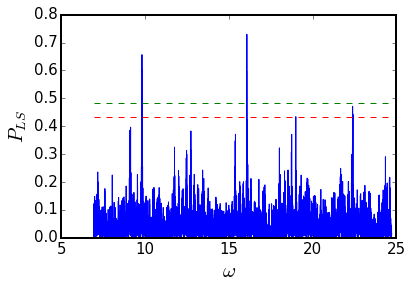

In [303]:


# provided alternate frequency function
# I call omega angular frequency, and 'frequency' the other one...
#  freq = 1  / Period   ,   omega =  2 pi  /  Period  ,   
# omega = 2 pi * freq  

def alt_omega_grid(Pmin, Pmax, n_bins = 5000):
    """Generate an angular frequency grid between Pmin and Pmax (assumed to be in days)"""
    omega_max = 2*np.pi / Pmin
    omega_min = 2*np.pi / Pmax
    return np.linspace(omega_min, omega_max, n_bins)


# Cheating : since we know that these are RR Lyrae,  
# search on a grid between smallest and largest 
# possible period... 
all_periods = table2['Per'].data
omegas = alt_omega_grid(min(all_periods),max(all_periods), 5000)  

#omegas = freq.frequency_grid(mjds) 
P_LS = lomb_scargle(t=mjds,y=mags, dy=magerrs, omega=omegas)
plt.plot(omegas, P_LS)
plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')
#plt.plot(frequency, P_LS)


# provided: define function to find best period
def LS_peak_to_period(omegas, P_LS):
    """find the highest peak in the LS periodogram and return the corresponding period."""
    max_omega = omegas[np.argmax(P_LS)]
    return 2*np.pi/max_omega


D = lomb_scargle_bootstrap(t=mjds, y=mags, dy=magerrs, omega=omegas, N_bootstraps=500) # Bootstrapped LS 
sig99, sig95 = np.percentile(D,99) , np.percentile(D,95) 

plt.plot([omegas[0],omegas[-1]], sig99*np.ones(2),'--')
plt.plot([omegas[0],omegas[-1]], sig95*np.ones(2),'--')

# run function to find best period
best_period = LS_peak_to_period(omegas, P_LS)
print("Best period: {} days".format(best_period))

Fold the lightcurve on that period...

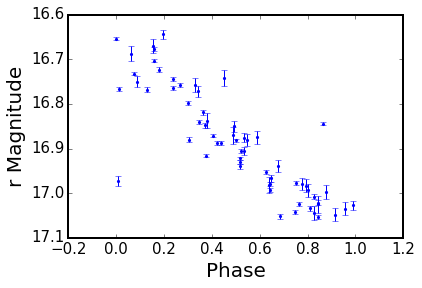

In [242]:
fig,ax = plt.subplots()
plot_phased_lc(majds, mags, magerrs, best_period, None, ax, band)

Wrap all these functions so that I can take a lightcurve, plot its raw lightcurve, fold on the true period (from Table 2), compute periodogram, and fold on the best-fit period.  I use AstroML Lomb-Scargle periodogram implementation, setting as the minimum period the shortest period amongst RR Lyr from Branimir's sample -10%, and similarly with the longest period: + 10%.  This educated guess allows us to get close to the true frequency. By default,  both AstroPy and AstroML do not span the frequencies high enough (short periodicities). 

In [460]:
5 not in PDAC_i

False

In [516]:
def plot_rr_lyr( i = 0, band='g' , table2 = table2, save_plot=False, source='Sesar'):
    
    # directory with RR Lyr lightcurves 
    DirIn = '../catalogs/RRLyr_S82_Sesar_2010/'
    address1 = DirIn + 'table1_lightcurves/'
    lc_names = table2['Num'].data.astype(str)
    
    # grab Branimir's period and type for that particular RR Lyr...
    true_period = table2['Per'][i]  # in days 
    rr_type = table2['Type'][i] # string 
    ID = table2['Num'][i] # int
    
    omega_true = 2*np.pi / true_period
    print('We picked RR Lyrae ID=%d , type %s, with a period of %.6f days'%(ID,rr_type, true_period))
    print('True omega = %.4f'%omega_true)

    if source == 'Sesar':
    
        # Pick an RR Lyr, print it's mag,  type, and plot the lightcurve 
        lc = Table.read(address1+lc_names[i]+'.dat', format='ascii')

        # grab colnames and units for all RR Lyr LC lightcurves  from the readme file....
        readme = Table.read(address1+'ReadMe', format='ascii')

        # Rename the columns and units for this lightcurve ...
        columns = lc.colnames

        for j in range(len(columns)):
            lc[columns[j]].name = readme.colnames[j]
            lc[readme.colnames[j]].unit = readme[readme.colnames[j]].unit

        # grab the lightcurve data ... 
        mask =  lc[band+'mag'] > 0   # remove all rows missing data... 
        mjds = lc[band+'mjd'][mask]
        mags = lc[band+'mag'][mask]
        magerrs = lc[band+'magErr'][mask]
    
    if source =='PDAC' : 
        
        # Pick an RR Lyr
        address = '../raw_data/RRLyr_S82_PDAC/'
        PDAC_lcs = os.listdir(address)
        PDAC_IDs = np.array([str.rsplit(x,'_')[0] for x in PDAC_lcs]).astype(int)  
        PDAC_i = np.array([str.rsplit(x,'_')[1] for x in PDAC_lcs]).astype(int)
        
        if i not in PDAC_i : 
            print('Sorry, we do not have lightcurve i=%d, ID=%d from PDAC yet'%(i,ID ))
        else : 
            lc = Table.read(address+lc_names[i]+'_'+str(i)+'_'+band+'.txt', format='ascii')
            lc_clean = lc[~lc['g'].mask]  # remove all missing rows... 
            # grab the lightcurve data ...
            mjds = np.array(lc_clean['exposure_time_mid'])
            mags = np.array(lc_clean[band])
            magerrs = np.array(lc_clean[band+'Err'])
            
    # Make plot space
    fig,axs = plt.subplots(2,2,figsize=(14,8))
    ax = np.ravel(axs)
        
    # plot the raw lightcurve...
    plot_data(mjds,mags, magerrs, ax[0], band)
    xticks = ax[0].get_xticks()
    ax[0].set_xticks(xticks[1::2])
    
    # plot phased lightcurve using  Branimir's period 
    plot_phased_lc(mjds, mags, magerrs, true_period, None, ax[1], band, 2)

    # Creative guess : since we know that these are RR Lyrae,  
    # search on a grid between  the smallest and largest 
    # possible period... 
    all_periods = table2['Per'].data
    omegas = alt_omega_grid(0.9 * min(all_periods),1.1*max(all_periods), 5000)  

    #omegas = freq.frequency_grid(mjds) 
    P_LS = lomb_scargle(t=mjds,y=mags, dy=magerrs, omega=omegas)
    
    # plot the periodogram
    ax[2].plot(omegas, P_LS)
    ax[2].set_xlabel('$\omega$')
    ax[2].set_ylabel('$P_{LS}$')
    
    # run bootstrapped resamples to get significance....
    D = lomb_scargle_bootstrap(t=mjds, y=mags, dy=magerrs, omega=omegas, N_bootstraps=100) # Bootstrapped LS 
    sig99, sig95 = np.percentile(D,99) , np.percentile(D,95) 

    ax[2].plot([omegas[0],omegas[-1]], sig99*np.ones(2),'--')
    ax[2].plot([omegas[0],omegas[-1]], sig95*np.ones(2),'--')
    # plt.arrow(x,y,dx,dy)
    #ax[2].arrow(omega_true, 0.2, 0, -0.1, head_width=0.5, head_length=0.1, fc='red', ec='red') 
    
    # run function to find best period
    omega_best = omegas[np.argmax(P_LS)]
    best_period =  2*np.pi/omega_best
    print("Best period: %.6f days"%(best_period))
    print("Best omega %.4f"%omega_best)
    
    ax[2].axvline(omega_best, ymax=0.5, ls='--', lw=3, color='orange', label=r'$\omega_{fit}$')
    ax[2].axvline(omega_true, ymax=0.5, ls='-.', lw=3, color='magenta', label=r'$\omega_{true}$')
    
    ax[2].legend(fontsize=15)
    
    # plot phased lightcurve phased using  the LS-best fit period
    plot_phased_lc(mjds, mags, magerrs, best_period, None, ax[3], band,2)
    
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    if save_plot  :
        fname = '../data_products/Fig_2_RRLyr_LS_periodogram_ID_'+str(ID)+'_'+band+source+'.png'
        plt.savefig(fname)
        print('Figure saved to %s'%fname)
        


We picked RR Lyrae ID=13350 , type ab, with a period of 0.547987 days
True omega = 11.4659
Best period: 0.547969 days
Best omega 11.4663
Figure saved to ../data_products/Fig_2_RRLyr_LS_periodogram_ID_13350_gPDAC.png


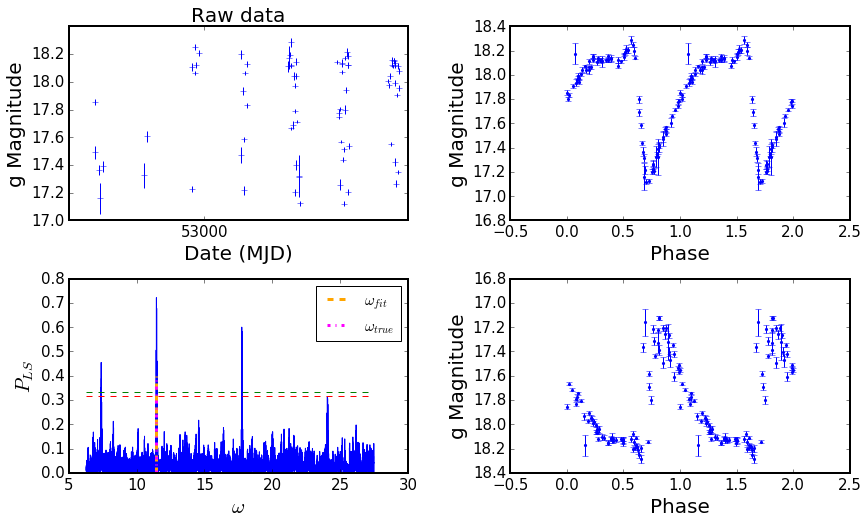

In [519]:
plot_rr_lyr(i=1, save_plot=True, source='PDAC')

In [317]:
# TIME IT !!!!

%timeit lomb_scargle(t=mjds,y=mags, dy=magerrs, omega=omegas)


100 loops, best of 3: 18.6 ms per loop


Since with that one lightcurve I see that the periods are not identical, let's test that for all 483 lightcurves in Branimir's sample :

[ takes about 10 secs on the mac to run.  For each lightcurve, I run the periodogram on 5000 frequencies spaced from 
    
    0.9 * (smallest_period_in_table_2)  -   1.1 * (longest_period_in_table_2)
]

In [342]:
# check : for how many RR Lyr my  best-fit period is different from Branimir's by more than 10%...

# directory with RR Lyr lightcurves 
DirIn = '../catalogs/RRLyr_S82_Sesar_2010/'
address1 = DirIn + 'table1_lightcurves/'
lc_names = table2['Num'].data.astype(str)

# grab colnames and units for all RR Lyr LC lightcurves  from the readme file....
readme = Table.read(address1+'ReadMe', format='ascii')

ratios = np.ones_like(lc_names, dtype=float)
fit_period  = np.ones_like(lc_names, dtype=float)

for i in range(len(lc_names)):  # 
    
    # Pick an RR Lyr, print it's mag,  type, and plot the lightcurve 
    lc = Table.read(address1+lc_names[i]+'.dat', format='ascii')

    # Rename the columns and units for this lightcurve ...
    columns = lc.colnames

    for j in range(len(columns)):
        lc[columns[j]].name = readme.colnames[j]
        lc[readme.colnames[j]].unit = readme[readme.colnames[j]].unit

    # grab Branimir's period and type for that particular RR Lyr...
    true_period = table2['Per'][i]  # in days 
    rr_type = table2['Type'][i] # string 
    ID = table2['Num'][i] # int
    
    omega_true = 2*np.pi / true_period
    #print('We picked RR Lyrae ID=%d , type %s, with a period of %.4f days'%(ID,rr_type, period))
    #print('True omega = %.4f'%omega_true)
    
    # Creative guess : since we know that these are RR Lyrae,  
    # search on a grid between  the smallest and largest 
    # possible period... 
    all_periods = table2['Per'].data
    omegas = alt_omega_grid(0.9 * min(all_periods),1.1*max(all_periods), 5000)  

    #omegas = freq.frequency_grid(mjds) 
    
    mask = lc[band+'mag'] > 0   # remove all rows missing data...  (the -99.99 rows...)
    mjds = lc[band+'mjd'][mask]
    mags = lc[band+'mag'][mask]
    magerrs = lc[band+'magErr'][mask]
    
    P_LS = lomb_scargle(t=mjds,y=mags, dy=magerrs, omega=omegas)
   
    # run function to find best period
    omega_best = omegas[np.argmax(P_LS)]
    best_period =  2*np.pi/omega_best
    fit_period[i] = best_period
    
    #print("Best period: {} days".format(best_period))
    #print("Best omega %.4f"%omega_best)
    ratio = omega_true / omega_best
    #print('Omega_true / Omega_fit = %f'%ratio)
    ratios[i] = ratio



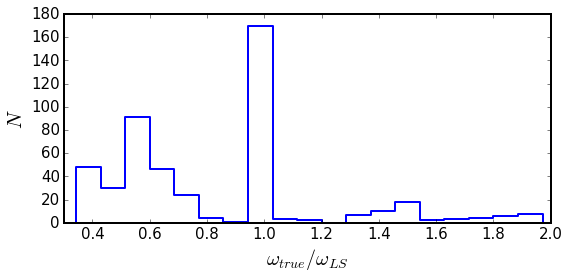

In [368]:
# Plot ratio of my calculated omega,  vs  omega from Branimir's table...

fig,ax = plt.subplots(1,1,figsize=(8,4))

# Using numpy over ax.hist  helps let the center of 
# the rectangle stay over the bin center, 
# rather than the bin edge...

hist, bin_edges = np.histogram(ratios, bins=np.linspace(0.3,2.1,22
                                                       ), density=False)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
hist[0] = 0
ax.plot(bin_centres, hist, ls = 'steps', lw=2, color = 'blue')
#ax.hist(ratios, bins=40, histtype='step', lw=2)

ax.set_xlabel(r'$ \omega_{true} / \omega_{LS}$')
ax.set_ylabel(r'$N$')
ax.set_xlim(0.3,2.0)
plt.tight_layout()
fname = '../data_products/Fig_3_RRLyr_omega_ratio.png'
plt.savefig(fname)

Get the demographics:  how many RR Lyrae is in each group... I call  ratio the $\omega_{true}/ \omega_{LS}$


In [344]:
print('There are %d RR Lyrae with ratio < 0.9'%np.sum(ratios<1))
print('There are %d RR Lyrae with |ratio-1.0|<0.1'%np.sum(np.abs(ratios-1)<0.1))
print('There are %d RR Lyrae with ratio > 1.1'%np.sum(ratios>1))

There are 330 RR Lyrae with ratio < 0.9
There are 173 RR Lyrae with |ratio-1.0|<0.1
There are 153 RR Lyrae with ratio > 1.1


Choose one RR Lyr in the 'left' group, and one in the 'right' group (i=1 plotted above already falls in the 'middle' group.)

In [376]:
# left group... 
master_table['i'][ratios<0.6].data

array([  0,  14,  18,  19,  37,  40,  41,  46,  56,  58,  61,  63,  64,
        72,  73,  75,  78,  80,  88,  94, 101, 104, 107, 111, 122, 126,
       134, 138, 144, 147, 148, 154, 159, 165, 171, 180, 187, 191, 212,
       216, 220, 228, 230, 231, 249, 250, 253, 255, 256, 262, 264, 275,
       305, 308, 314, 322, 323, 324, 330, 332, 343, 349, 350, 353, 358,
       360, 378, 383, 384, 393, 394, 395, 396, 397, 402, 405, 413, 420,
       424, 430, 433, 435, 437, 438, 440, 444, 445, 446, 455, 457, 458,
       463, 466, 467, 471, 473, 478])

In [388]:
ratios[0]

0.43759246501556948

We picked RR Lyrae ID=4099 , type ab, with a period of 0.641754 days
True omega = 9.7906
Best period: 0.280827 days
Best omega 22.3739
Figure saved to ../data_products/Fig_2_RRLyr_LS_periodogram_ID_4099_g.png


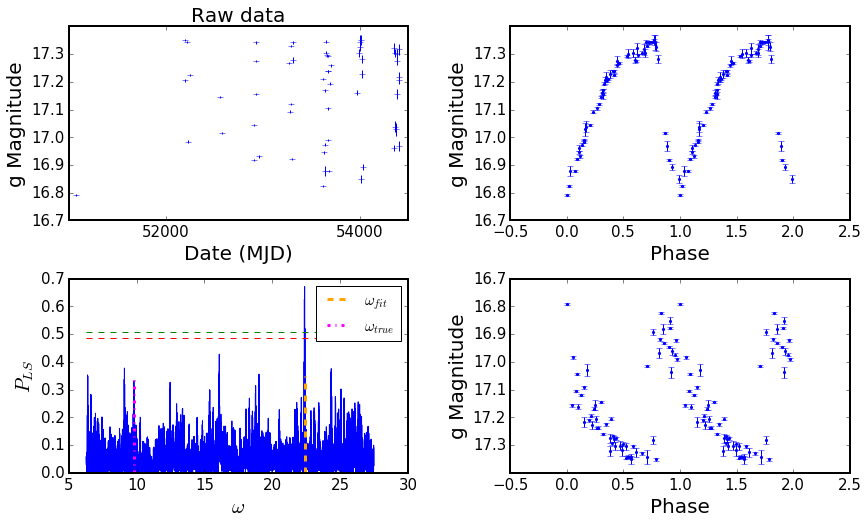

In [382]:
plot_rr_lyr(i=0, band='g', save_plot=True)

In [383]:
# right group... 
master_table['i'][ratios>1.5].data

array([ 33,  43,  44,  59,  74,  89,  97, 114, 131, 133, 136, 141, 168,
       177, 182, 207, 209, 214, 217, 223, 242, 244, 246, 258, 276, 280,
       284, 327, 346, 357, 359, 370, 372, 375, 380, 392, 398, 411, 418,
       450, 454, 462, 468, 482])

In [389]:
ratios[59]

1.5330928328797033

We picked RR Lyrae ID=470994 , type c, with a period of 0.346794 days
True omega = 18.1179
Best period: 0.531667 days
Best omega 11.8179
Figure saved to ../data_products/Fig_2_RRLyr_LS_periodogram_ID_470994_g.png


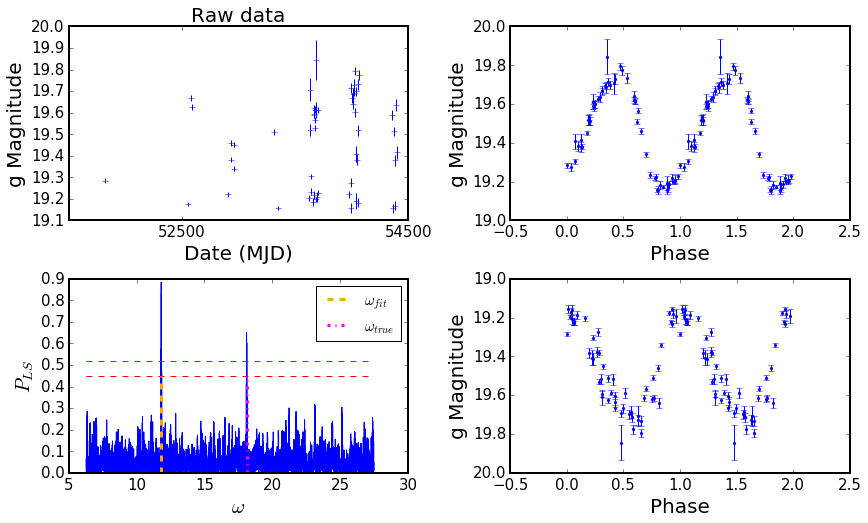

In [387]:
plot_rr_lyr(i=59, band='g', save_plot=True)

## Select a few objects, grab data from PDAC, see what results we get...

In [249]:
master_table[:5]

i,RAdeg,DEdeg,Num,Type,Per,gmag
,,,,,d,mag
int64,float64,float64,int64,str2,float64,float64
0,0.935679,1.115859,4099,ab,0.641754351271,16.6637400636
1,0.283437,1.178522,13350,ab,0.547987422171,16.9886134861
2,3.254658,-0.584066,15927,ab,0.612262983773,17.6534916127
3,3.244369,0.218891,20406,ab,0.631853138777,15.2059062035
4,4.315354,1.054582,21992,ab,0.625880355362,14.3769955855


## Downloading the RR Lyr data from PDAC 

Very counter-intuitive (why "separate rows in the table result from the measurements in each band” ?  ) . I am guessing based on the example SQL queries from https://confluence.lsstcorp.org/display/DM/PDAC+sample+queries+and+test+cases#PDACsamplequeriesandtestcases-Forreturningtheflux  rather than anything else, what the columns in Catalogs --> Deep Forced Source mean.  And from 


    SELECT
        objectId,
        id,
        fsrc.exposure_id,
        fsrc.exposure_time_mid,
        exp.run,
        scisql_dnToFlux(fsrc.flux_psf, exp.fluxMag0) AS tsv_flux,
        scisql_dnToFluxSigma(fsrc.flux_psf, fsrc.flux_psf_err, exp.fluxMag0, exp.fluxMag0Sigma) AS tsv_fluxErr
    FROM
        RunDeepForcedSource AS fsrc,
        Science_Ccd_Exposure AS exp
    WHERE
            exp.scienceCcdExposureId = fsrc.exposure_id
        AND fsrc.exposure_filter_id = 1
        AND NOT (fsrc.flagPixEdge     | fsrc.flagPixSaturAny |
                 fsrc.flagPixSaturCen | fsrc.flagBadApFlux |
                 fsrc.flagBadPsfFlux)
        AND objectId = 3448068867358968
    ORDER BY
        exposure_time_mid

    
which they use to return the flux ("Computing a calibrated flux requires correcting the observed flux for the photometric zero point.  This requires a join between the RunDeepForcedSource table, for the information about the individual observations, and the Science_Ccd_Exposure table (for a per-visit-image photometric zero point)".)  , I guess that for RunDeepForcedSource, 

          exposure_id, exposure_time_mid,  flux_psf,  flux_psf_err   

are columns of interest, and that we also need to grab from the exposure table (Science_Ccd_Exposure)
      scienceCcdExposureId, run, fluxMag0, fluxMag0Sigma
    
If we use shorthand notation  

      RunDeepForcedSource   == fsrc
      Science_Ccd_Exposure ==  exp
    
then  

    fsrc.exposure_id  <==>  exp.scienceCcdExposureId
    
They choose g-band by restricting  
    
    fsrc.exposure_filter_id = 1
    


To reproduce the above, but without executing 

    curl -d 'query=SELECT objectId, id, fsrc.exposure_id, fsrc.exposure_time_mid, exp.run, scisql_dnToFlux(fsrc.flux_psf,exp.fluxMag0) AS tsv_flux, scisql_dnToFluxSigma(fsrc.flux_psf, fsrc.flux_psf_err, exp.fluxMag0, exp.fluxMag0Sigma) AS tsv_fluxErr FROM RunDeepForcedSource AS fsrc, Science_Ccd_Exposure AS exp WHERE exp.scienceCcdExposureId = fsrc.exposure_id AND fsrc.exposure_filter_id=1 AND objectId=3448068867358968 ORDER BY exposure_time_mid' http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync
   
(by the way, when I execute that I have no idea in what format is my data returned....Is it an IPAC table ? Doesn't look like it ... ) 


Using the interface very easily becomes cumbersome.  To get calibrated flux, I need to : 

1) download from Catalog --> Deep Forced Source,  query  with 23.201735,1.029917,  radius 2 arcsec for cone search,   grabbing the above (there is no single id that would be held constant for the same source...)  Even for this narrow cone, I get objectId 2674023418832533  and 2674023418827266 . If I decrease the cone to the smallest allowed value (1 arcsec), I still get the same  two objectId's . 

Need to also grab  
    (fsrc.flagPixEdge     | fsrc.flagPixSaturAny |  fsrc.flagPixSaturCen | fsrc.flagBadApFlux |
     fsrc.flagBadPsfFlux)
and remove all rows where this is nonzero. 


Save also the  cols : 
    
    id, objectId,  exposure_filter_id , exposure_id, exposure_time_mid,  flux_psf,  flux_psf_err, 
    
( I would also grab coord_ra  , coord_dec , to show that indeed this is one , and not two, objects...  The SQL query seems to rely on the fact that different objectIds correspond to different objects, but here I get that it is one and the same object....) 

2) download from Images --> Science CCD Exposure, querying against 23.201735,1.029917  ,  and keeping 

    run, fluxMag0, fluxMag0Sigma, scienceCcdExposureId
    
3) Join the two tables on 
    
    fsrc.exposure_id  <==>  exp.scienceCcdExposureId
    
4) Calculate calibrated flux, fluxErr  using  flux_psf  , flux_psf_err, fluxMag0, fluxMag0Sigma - how is it done ? Tey use some built-in functions 

    scisql_dnToFlux()  scisql_dnToFluxSigma()
    
    
But I would have to code it from the scratch....

much info on the S82 tables is available here:   https://dev.lsstcorp.org/trac/wiki/DC/Winter2013 

I looked and looked for these two scisql  functions.... I found github pages that seem to be related to its development : https://github.com/smonkewitz/scisql  https://github.com/lsst/scisql  

In essence : very laborious... 

## Use SQL queries to get the data, and then analyze here: 



In [257]:
row = master_table['Num'] == 1013184
master_table[row]

i,RAdeg,DEdeg,Num,Type,Per,gmag
,,,,,d,mag
int64,float64,float64,int64,str2,float64,float64
112,23.201735,1.029917,1013184,ab,0.614318300907,16.6837837725


i=112, RR Lyr ID=1013184, type= ab, period = 0.614318, RA, dec = 23.201735,1.029917, gmag=16.683784

### 1) Query RunDeepForcedSource against RA,DEC : find objectIds in the circle 

1) Query the RunDeepForcedSource to find out what are objectIds within a tiny circle centered on the desired RA, dec  : ( I SELECT objectId  only ,  to make it easier to search the output JSON file for unique values...(
  
  a) using qserv functions : 
    
    
     curl -o catalogCone.json \
                -d 'query=SELECT+objectId+FROM+RunDeepForcedSource+WHERE+qserv_areaspec_circle(23.201735,1.029917,0.00055);' \
                http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync
    
  
   
    above, the center RA is 23.201735,  center dec 1.029917 , and the search radius is 2 / 3600 = 0.00055 degrees,
    and catalogCone.json  is the json file produced by the query 
    
    
    
  ( same can be done using scisql functions :
   
     curl -o catalogCone.json \
                -d     'query=SELECT+objectId+FROM+RunDeepForcedSource+WHERE+scisql_s2PtInCircle(coord_ra,coord_decl,23.201735,1.029917,0.00055)=1;' \
                http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync
  )

Read the JSON file : 
    

    

In [534]:
# solution from 
# https://dzone.com/articles/python-reading-json-file 


json_file = '../raw_data/catalogCone.json'
tab = json.loads(open(json_file).read())


In [535]:
tab['result']['table'].keys()

dict_keys(['data', 'metadata'])

In [536]:
meta = tab['result']['table']['metadata']['elements']

for i in range(len(meta)):
    print(meta[i]['name'])

objectId


In [538]:
# find what are the unique objectId's  within this cone search 
# ravel flattens all the data, since I queried for objectId only... 
np.unique(np.ravel(tab['result']['table']['data']))

array([2674023418827266, 2674023418832533])

### 2) Query RunDeepForcedSource  and Science_Ccd_Exposure given objectIds,  to get calibrated magnitudes

2) Query with these objectIds against the RunDeepForcedSource  and Science_Ccd_Exposure   tables,  to get 
calibrated magnitudes : 

    SELECT
        objectId,
        id,
        fsrc.exposure_id,
        fsrc.exposure_time_mid,
        exp.run,
        scisql_dnToAbMag(fsrc.flux_psf, exp.fluxMag0) AS g,
        scisql_dnToAbMagSigma(fsrc.flux_psf, fsrc.flux_psf_err, exp.fluxMag0, exp.fluxMag0Sigma) AS gErr
    FROM
        RunDeepForcedSource AS fsrc,
        Science_Ccd_Exposure AS exp
    WHERE
            exp.scienceCcdExposureId = fsrc.exposure_id
        AND fsrc.exposure_filter_id = 1
        AND NOT (fsrc.flagPixEdge     | fsrc.flagPixSaturAny |
                 fsrc.flagPixSaturCen | fsrc.flagBadApFlux |
                 fsrc.flagBadPsfFlux)
        AND objectId IN (2674023418827266,2674023418832533)
    ORDER BY
        exposure_time_mid


To the first line of curl  expression, I add -o catalogCone.json  , before -d,   to output to a file : 

    curl -o catalogForced.json -d 'query=SELECT objectId, id, fsrc.exposure_id, fsrc.exposure_time_mid, exp.run, scisql_dnToAbMag(fsrc.flux_psf,exp.fluxMag0) AS g, scisql_dnToAbMagSigma(fsrc.flux_psf, fsrc.flux_psf_err, exp.fluxMag0, exp.fluxMag0Sigma) AS gErr FROM RunDeepForcedSource AS fsrc, Science_Ccd_Exposure AS exp WHERE exp.scienceCcdExposureId = fsrc.exposure_id AND fsrc.exposure_filter_id=1 AND objectId IN (2674023418827266, 2674023418832533) ORDER BY exposure_time_mid' http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync

Read the output : 

In [539]:
json_file= '../raw_data/catalogForced.json'
tab = json.loads(open(json_file).read())

print(tab['result']['table'].keys())
print(tab['result']['table']['metadata']['elements'])

meta = tab['result']['table']['metadata']['elements']
data = tab['result']['table']['data']
dataT = np.transpose(data)



t = Table()

# iterate over columns...
for i in range(len(dataT)):
    t.add_column(Column(dataT[i], name=meta[i]['name']), index=0)

In [546]:
# pull only those epochs where we have an existing measurement 

mask = np.isfinite(t['g'].data.astype(float))

# show that indeed all info is stored correctly, and indeed we have been able to grab photometry 
# for the same object, but with two different objectId's..
np.unique(t[mask]['objectId'].astype(int))

2674023418827266
2674023418832533


In [547]:
t[:5]

gErr,g,run,exposure_time_mid,exposure_id,id,objectId
float64,float64,float64,float64,float64,float64,float64
0.0180446796993,17.0486095197,1755.0,51819.4209479,1755160531.0,1.17786829373e+17,2.67402341883e+15
0.0180446317532,17.0483672826,1755.0,51819.4209479,1755160531.0,1.17786829373e+17,2.67402341883e+15
0.0171980667495,17.5825166235,2886.0,52288.0801157,2886160064.0,1.93686923217e+17,2.67402341883e+15
0.017198059783,17.582496621,2886.0,52288.0801157,2886160064.0,1.93686923217e+17,2.67402341883e+15
0.0349384939406,17.2265218177,3325.0,52522.3823283,3325160263.0,2.23147727868e+17,2.67402341883e+15


Plot raw g-band data from PDAC  for RR Lyr ID = 1013184 : 

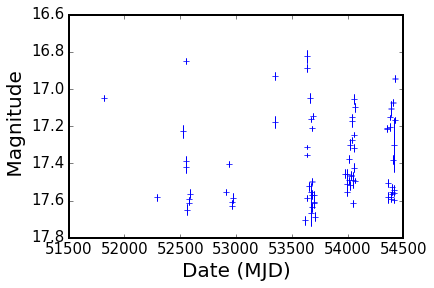

In [548]:

fig,ax = plt.subplots()
plot_data(t['exposure_time_mid'], t['g'], t['gErr'], ax)


#### Fold the PDAC g-band data on the period from Sesar+2010 : 

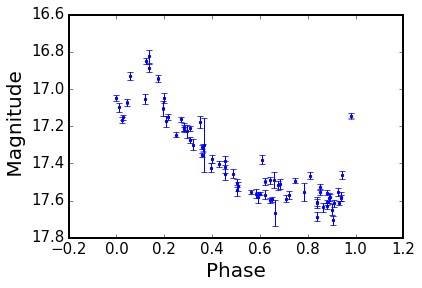

In [549]:

fig,ax = plt.subplots()
plot_phased_lc(t['exposure_time_mid'], t['g'], t['gErr'], 0.614318, t0=None, ax = ax, band='')

#### Plot the Sesar+2010 S82 data : raw and folded 

We picked RR Lyrae ID=1013184 , type ab, with a period of 0.614318 days
True omega = 10.2279
Best period: 0.614323034801143 days
Best omega 10.2278


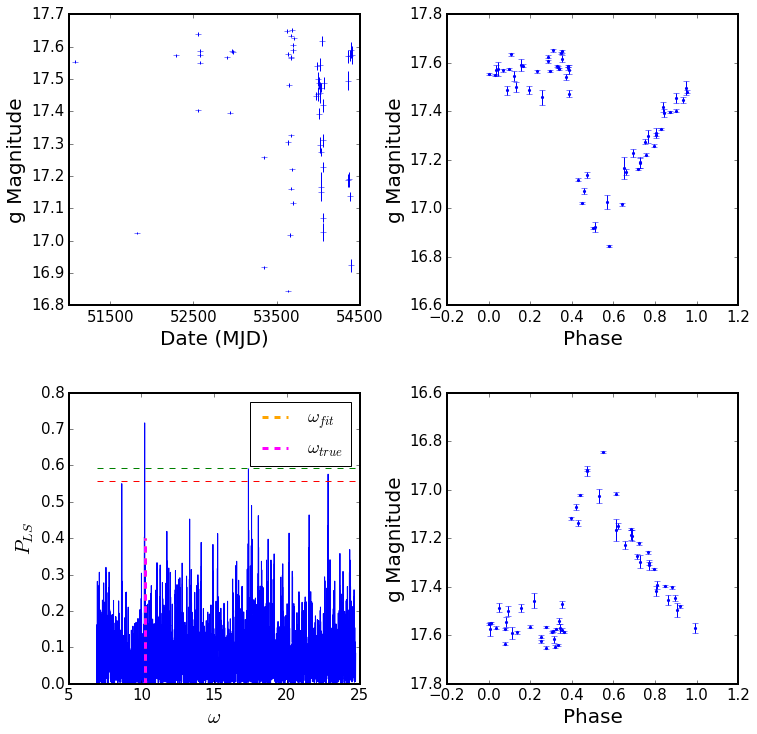

In [531]:
plot_rr_lyr(i=0, band='g')

### Compare against NASA Exoplanet Archive 

To use the Exoplanet Archive , I need a clean  mjd,mag,magerr lightcurve with no bad data.  Thus I take a few lightcurves from Branimir's  sample, and split them into separate files, each having one band, removing the bad data (-99.99 rows).



In [254]:



# Read in a particular RR Lyr...
lc_names = table2['Num'].data.astype(str)

for i in range(5) : 

    lc = Table.read(address1+lc_names[i]+'.dat', format='ascii')

    # Grab the colnames and units from the 
    # Readme file...
    columns = lc.colnames

    for j in range(len(columns)):
        lc[columns[j]].name = readme.colnames[j]
        lc[readme.colnames[j]].unit = readme[readme.colnames[j]].unit

    # Display some info about this particular RR Lyr ...
    print('\nFor RR Lyr ID=%d, type= %s, period = %f, RA, dec = %f,%f, gmag=%f'%(master_table[i]['Num'],
                                                                             master_table[i]['Type'],
                                                                             master_table[i]['Per'],
                                                                             master_table[i]['RAdeg'], 
                                                                             master_table[i]['DEdeg'],
                                                                             master_table[i]['gmag']))
    # Save the lightcurve in a given band 'cleared' on the -99  measurements( which indicate a lack of measurement...)
    # name:  RRLyrID_band.dat
    for band in 'ugriz':
        good_rows = lc[band+'mag'].data != -99.99
        print('       For ID=%d, in %s band we removed %d bad rows'%(master_table[i]['Num'],band,np.sum(~good_rows)))
        mjd = lc[band+'mjd'][good_rows]
        mag = lc[band+'mag'][good_rows]
        magerr = lc[band+'magErr'][good_rows]

        data = np.column_stack((mjd,mag,magerr))
        DirOut = '../raw_data/RRLyr_S82_Sesar_2010_LC/'
        fname = str(lc_names[i])+'_'+band+'.txt'
        # formatting keeps the original accuracy of MJD, and photometry 
        np.savetxt(DirOut+fname, data, fmt='%10.6f %10.3f %10.3f')

print('Cleared lightcurves, split into bands, removing "-99.99 points", saved to %s' % DirOut)


For RR Lyr ID=4099, type= ab, period = 0.641754, RA, dec = 0.935679,1.115859, gmag=16.663740
       For ID=4099, in u band we removed 20 bad rows
       For ID=4099, in g band we removed 5 bad rows
       For ID=4099, in r band we removed 1 bad rows
       For ID=4099, in i band we removed 2 bad rows
       For ID=4099, in z band we removed 8 bad rows

For RR Lyr ID=13350, type= ab, period = 0.547987, RA, dec = 0.283437,1.178522, gmag=16.988613
       For ID=13350, in u band we removed 3 bad rows
       For ID=13350, in g band we removed 7 bad rows
       For ID=13350, in r band we removed 2 bad rows
       For ID=13350, in i band we removed 4 bad rows
       For ID=13350, in z band we removed 5 bad rows

For RR Lyr ID=15927, type= ab, period = 0.612263, RA, dec = 3.254658,-0.584066, gmag=17.653492
       For ID=15927, in u band we removed 13 bad rows
       For ID=15927, in g band we removed 3 bad rows
       For ID=15927, in r band we removed 2 bad rows
       For ID=15927, in i ban

Focus on the object that I got from PDAC : 

Do the same object with Exoplanet Archive... ( I set min period=0.254146, max period =0.907497 [days]). I upload the cleaned g-magnitude lightcurve : 

    '../raw_data/RRLyr_S82_Sesar_2010_LC/1013184_g.txt' 

email of Feb 17, 2017, from Zeljko : 
    
  "when you run periodogram for a few stars, could you please also
try this service and compare to your independent results:
http://exoplanetarchive.ipac.caltech.edu/cgi-bin/Pgram/nph-pgram

In addition to comparing periods (or the whole periodograms), it’d
be great to have a statement about the compute speed.

   Z.""

In Exoplanet Archive, I use these as the lower / upper bounds on periods to search   (same as when I am using AstroML periodogram...)

In [146]:
print('min period=%f, max period =%f [days]'%(0.9*min(all_periods), 1.1*max(all_periods)))



min period=0.228731, max period =0.998246 [days]


    --> uploading tiniest file takes ~10 secs
    --> entering min and max periods,  choosing 'Lomb Scargle' and 'Fixed Frequency', I get step size of 0.0001678 
    --> calculating takes ~15 secs 

Best Period (Rank1) : 0.614320  ( I saved the periodogram file in ../data_products/Exoplanet...) 
    
        \
    \ Periodogram Table of Peaks File
    \
    \ Input File=1013184_g.txt
    \ Time Column=col1
    \ Data Column=col2
    \ Algorithm=ls
    \ Min Period=0.254146
    \ Max Period=0.907497
    \ Step Method=fixedf
    \ Fixed Step Size=0.000168
    \ Number of Peaks=50
    \ Peak Significant Threshold=1.000000
    \ NSamplesForStat=16883
    \
    |Peak |Period              |Power               |Frequency           |SDE                 |
    |int  |double              |double              |double              |double              |
     1     0.6143195866         19.7613657201        1.6278172173         19.7613657201     

<img src="figures/1013184_g_periodogram.png" width=500>

## Do the same for another RA, dec ... 


i=1, RR Lyr ID=1019544, type= ab, period = 0.622447, RA, dec = -23.690417,-0.104992, gmag=15.410343

... and make it automatic! 

Pipeline : 
    * query RunDeepForcedSource Table in cone search qserv_areaspec_circle(ra,dec, search_radius_degrees)
    * identify unique objectId in this circle
    * query RunDeepForcedSource and Science_Ccd_Exposure  to get AB magnitudes

First, do for one object : 

In [258]:
import subprocess
#https://pymotw.com/3/subprocess/
# http://stackoverflow.com/questions/3729366/custom-standard-input-for-python-subprocess

master_table[0]

i,RAdeg,DEdeg,Num,Type,Per,gmag
,,,,,d,mag
int64,float64,float64,int64,str2,float64,float64
0,0.935679,1.115859,4099,ab,0.641754351271,16.6637400636


In [259]:
i=0
ra_deg = str(master_table[i]['RAdeg'])
dec_deg = str(master_table[i]['DEdeg'])
search_radius_deg = str(2/3600.0)[:9]

# query against that object... 
cmd = "curl -o ../raw_data/PDAC_cone_search_results/catalogCone"+str(i)+".json \
                -d 'query=SELECT+objectId+FROM+RunDeepForcedSource+WHERE+qserv_areaspec_circle("\
                +ra_deg+","+dec_deg+","+search_radius_deg+");' \
                http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync"
completed = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE)

In [260]:
# find unique IDs
json_file = '../raw_data/PDAC_cone_search_results/catalogCone'+str(i)+'.json'
tab = json.loads(open(json_file).read())
objectIds = tuple(np.unique(np.ravel(tab['result']['table']['data'])))
print('In this query, we recover objectId :  ')
print(objectIds)
ids = str(objectIds)

In this query, we recover objectId :  
(3562429887808969, 3562429887812663)


In [261]:
# query against these ids 
cmd = " curl -o ../raw_data/PDAC_forced_phot_results/catalogForced"+str(i)+".json -d 'query=\
        SELECT \
            objectId, id, fsrc.exposure_id, fsrc.exposure_time_mid, exp.run, \
            scisql_dnToAbMag(fsrc.flux_psf,exp.fluxMag0) AS g, \
            scisql_dnToAbMagSigma(fsrc.flux_psf, fsrc.flux_psf_err, exp.fluxMag0, exp.fluxMag0Sigma) AS gErr \
        FROM \
            RunDeepForcedSource AS fsrc, \
            Science_Ccd_Exposure AS exp \
        WHERE \
            exp.scienceCcdExposureId = fsrc.exposure_id \
            AND fsrc.exposure_filter_id=1 \
            AND objectId IN "+ids+" \
        ORDER BY exposure_time_mid' http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync"
completed = subprocess.run(cmd, shell=True)

# NOTE  : exposure_filter_id  is where we choose which filter to use 
# u = 0
# g = 1 
# r = 2
# i = 3
# z = 4

In [263]:
json_file= '../raw_data/PDAC_forced_phot_results/catalogForced'+str(i)+'.json'
tab = json.loads(open(json_file).read())

#print(tab['result']['table'].keys())
#print(tab['result']['table']['metadata']['elements'])

meta = tab['result']['table']['metadata']['elements']
data = tab['result']['table']['data']
dataT = np.transpose(data)

t = Table()

# iterate over columns...
for i in range(len(dataT)):
    t.add_column(Column(dataT[i], name=meta[i]['name']), index=0)
    
# Save that as a txt file...
fname = '../raw_data/RRLyr_S82_PDAC/'+str(master_table['Num'][i])+'_'+str(i)+'_g.txt'
t.write(fname, format='ascii', overwrite='True')

Second, wrap and do for all objects...

In [269]:
len(lc_names)

483

In [270]:
print('Querying for i=%d, i.e. RR Lyr ID= %s'%(i, lc_names[i]))

# to store which objectIds corresponded to which RR Lyr... 
objectIds_per_i = {}

Querying for i=6, i.e. RR Lyr ID= 46988


In [293]:


for i in range(298,len(lc_names)):
    print('Querying for i=%d, i.e. RR Lyr ID= %s'%(i, lc_names[i]))
    ra_deg = str(master_table[i]['RAdeg'])
    dec_deg = str(master_table[i]['DEdeg'])
    search_radius_deg = str(2/3600.0)[:9]

    # query against that object... 
    cmd = "curl -o ../raw_data/PDAC_cone_search_results/catalogCone"+str(i)+".json \
                    -d 'query=SELECT+objectId+FROM+RunDeepForcedSource+WHERE+qserv_areaspec_circle("\
                    +ra_deg+","+dec_deg+","+search_radius_deg+");' \
                    http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync"
    completed = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE)

    # find unique IDs
    json_file = '../raw_data/PDAC_cone_search_results/catalogCone'+str(i)+'.json'
    tab = json.loads(open(json_file).read())
    objectIds = tuple(np.unique(np.ravel(tab['result']['table']['data'])))
    print('In this query, we recover objectId :  ')
    print(objectIds)
    if len(objectIds) == 1 : 
        ids=  '('+str(objectIds[0])+')'
    if len(objectIds) == 0 : 
        ids = None
        print('Skipping this query - no objects found within 2 arcsec! ')
    elif len(objectIds) > 1 : 
        ids = str(objectIds)
    objectIds_per_i[i] = ids 
    
    if len(objectIds) > 0 :  # only query if there is something to query with ! 
        
        # query PDAC against  ids found within 2 arcsec from our  input ra, dec ... 
        cmd = " curl -o ../raw_data/PDAC_forced_phot_results/catalogForced"+str(i)+".json -d 'query=\
                SELECT \
                    objectId, id, fsrc.exposure_id, fsrc.exposure_time_mid, exp.run, \
                    scisql_dnToAbMag(fsrc.flux_psf,exp.fluxMag0) AS g, \
                    scisql_dnToAbMagSigma(fsrc.flux_psf, fsrc.flux_psf_err, exp.fluxMag0, exp.fluxMag0Sigma) AS gErr \
                FROM \
                    RunDeepForcedSource AS fsrc, \
                    Science_Ccd_Exposure AS exp \
                WHERE \
                    exp.scienceCcdExposureId = fsrc.exposure_id \
                    AND fsrc.exposure_filter_id=1 \
                    AND objectId IN "+ids+" \
                ORDER BY exposure_time_mid' http://lsst-qserv-dax01.ncsa.illinois.edu:5000/db/v0/tap/sync"
        completed = subprocess.run(cmd, shell=True)

        # NOTE  : exposure_filter_id  is where we choose which filter to use 
        # u = 0
        # g = 1 
        # r = 2
        # i = 3
        # z = 4

        # Convert the output json file with g-band photometry to a text file...
        json_file= '../raw_data/PDAC_forced_phot_results/catalogForced'+str(i)+'.json'
        tab = json.loads(open(json_file).read())

        #print(tab['result']['table'].keys())
        #print(tab['result']['table']['metadata']['elements'])

        meta = tab['result']['table']['metadata']['elements']
        data = tab['result']['table']['data']
        dataT = np.transpose(data)

        # initialize a new AstroPy Table to store this S82 lightcurve from PDAC... 
        t = Table()

        # iterate over columns to add them to the Table ...
        for k in range(len(dataT)):
            t.add_column(Column(dataT[k], name=meta[k]['name']), index=0)

        # Save that as a txt file...
        fname = '../raw_data/RRLyr_S82_PDAC/'+str(master_table['Num'][i])+'_'+str(i).zfill(3)+'_g.txt'
        t.write(fname, format='ascii', overwrite='True')



Querying for i=298, i.e. RR Lyr ID= 2630747
In this query, we recover objectId :  
()
Skipping this query - no objects found within 2 arcsec! 
Querying for i=299, i.e. RR Lyr ID= 2639854
In this query, we recover objectId :  
()
Skipping this query - no objects found within 2 arcsec! 
Querying for i=300, i.e. RR Lyr ID= 2642610
In this query, we recover objectId :  
(217773680036416021, 217773680036419356)
Querying for i=301, i.e. RR Lyr ID= 2659801
In this query, we recover objectId :  
()
Skipping this query - no objects found within 2 arcsec! 
Querying for i=302, i.e. RR Lyr ID= 2666464
In this query, we recover objectId :  
()
Skipping this query - no objects found within 2 arcsec! 
Querying for i=303, i.e. RR Lyr ID= 2671427
In this query, we recover objectId :  
()
Skipping this query - no objects found within 2 arcsec! 
Querying for i=304, i.e. RR Lyr ID= 2672828
In this query, we recover objectId :  
()
Skipping this query - no objects found within 2 arcsec! 
Querying for i=305

FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/PDAC_cone_search_results/catalogCone448.json'

## Calculate periodograms, and find best period for PDAC lightcurves 

In [453]:
PDAC_lcs = os.listdir(address)
PDAC_IDs = np.array([str.rsplit(x,'_')[0] for x in PDAC_lcs])  
PDAC_i = np.array([str.rsplit(x,'_')[1] for x in PDAC_lcs]).astype(int)



In [455]:

# directory with PDAC RR Lyr lightcurves 
address = '../raw_data/RRLyr_S82_PDAC/'

lc_names = table2['Num'].data.astype(str)

# store the results 
store = {}
store['fit_period'] = np.zeros_like(lc_names, dtype=float)
store['ratio'] = np.zeros_like(lc_names, dtype=float)  

# at the moment, only g-band was obtained from PDAC, but can grab eg all filters next time.... 
# It just amounts to setting fsrc.exposure_filter_id =  0,1,2,3,4 ... 
# but I don't know if it can be done within a single SQL query....
band = 'g'

for i in PDAC_i :  # 
    
    # Pick an RR Lyr
    lc = Table.read(address+lc_names[i]+'_'+str(i)+'_'+band+'.txt', format='ascii')

    # grab Branimir's period and type for that particular RR Lyr...
    true_period = table2['Per'][i]  # in days 
    rr_type = table2['Type'][i] # string 
    ID = table2['Num'][i] # int
    
    omega_true = 2*np.pi / true_period
    
    # frequency grid... 
    all_periods = table2['Per'].data
    omegas = alt_omega_grid(0.9 * min(all_periods),1.1*max(all_periods), 5000)  

    mjds = lc['exposure_time_mid']
    mags = lc[band]
    magerrs = lc[band+'Err']
    
    P_LS = lomb_scargle(t=mjds,y=mags, dy=magerrs, omega=omegas)
   
    # run function to find best period
    omega_best = omegas[np.argmax(P_LS)]
    best_period =  2*np.pi/omega_best
    store['fit_period'][i] = best_period
    
    #print("Best period: {} days".format(best_period))
    #print("Best omega %.4f"%omega_best)
    ratio = omega_true / omega_best
    #print('Omega_true / Omega_fit = %f'%ratio)
    store['ratio'][i] = ratio




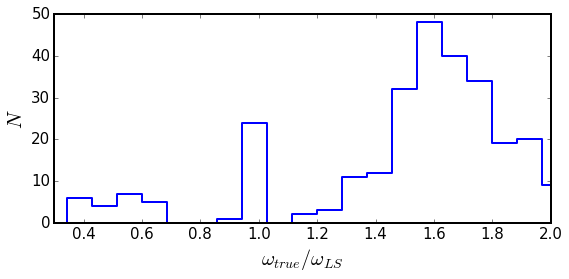

In [457]:
# Plot ratio of my calculated omega,  vs  omega from Branimir's table...

fig,ax = plt.subplots(1,1,figsize=(8,4))

# Using numpy over ax.hist  helps let the center of 
# the rectangle stay over the bin center, 
# rather than the bin edge...

ratios = store['ratio'][store['ratio'] != 0]

hist, bin_edges = np.histogram(ratios, bins=np.linspace(0.3,2.1,22
                                                       ), density=False)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
hist[0] = 0
ax.plot(bin_centres, hist, ls = 'steps', lw=2, color = 'blue')
#ax.hist(ratios, bins=40, histtype='step', lw=2)

ax.set_xlabel(r'$ \omega_{true} / \omega_{LS}$')
ax.set_ylabel(r'$N$')
ax.set_xlim(0.3,2.0)
plt.tight_layout()
fname = '../data_products/Fig_4_RRLyr_omega_ratio_PDAC.png'
plt.savefig(fname)

We picked RR Lyrae ID=13350 , type ab, with a period of 0.547987 days
True omega = 11.4659


/Users/chris/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


AttributeError: 'MaskedColumn' object has no attribute '_mask'

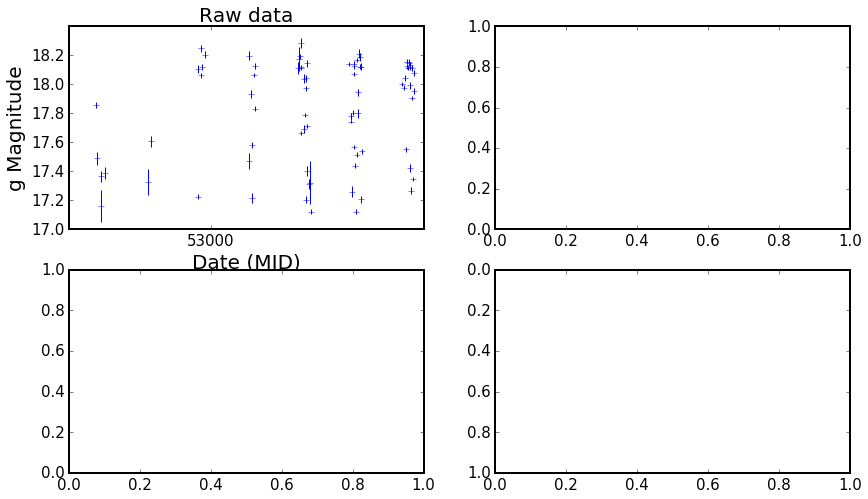

In [463]:
# Compare individual objects ... 
# Try i=1 : ID 13350
plot_rr_lyr(i=1, band='g', source='PDAC')
